In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from astropy.io import fits
import pandas as pd

import uncertainties as un
from uncertainties import unumpy

from scipy.optimize import fmin


font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]



# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s,   
}

In [46]:
M = Class()
M.set(websky_cosmo)

M.set({
          'output' :'dndlnM, m200m_to_m500c',
          'mass function' : 'T08',

          'concentration parameter': 'B13',


          'M_min' : 1e+13,#*websky_h, # bounds in websky:8.06216e+13 2.35569e+15,
          'M_max' : 5e+15,
    
          'z_min': 1e-3,
          'z_max': 4,
          'B': 1.7,

          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.0,
          'T_ncdm': 0.71611,



#           # # tabulation of mass function:
          'n_z_dndlnM' : 200,
          'n_m_dndlnM' : 200,
#           #
#           # # computation of mass function
#           # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 200,
          'ndim_redshifts' : 200,
    
        'y_m_relation' : 0, # planck 
     # scaling law parameter
     # Planck 2015    ?
    'ystar_ym': -0.186,
    'alpha_ym': 1.78,
    'beta_ym': 0.66,
    
    'load_Planck_noise_map': 1

    
})
M.compute()
print(M.sigma8())
print(M.get_sigma8_at_z(0.02))
# print(M.get_sigma8_at_z(0.0))

0.8099999005877047
0.803268963156724


In [47]:
z = 1.e0
m = np.geomspace(5e13,5e15,50)

y_planck = []
theta_planck = []
sigma_planck = []
for mm in m:
    y_planck.append(M.get_y_at_m_and_z(mm,z)) # does m/B internally for whichever B was set. 
    theta_planck.append(M.get_theta_at_m_and_z(mm,z)) # does m/B internally for whichever B was set. 
    sigma_planck.append(M.get_planck_sigma_at_theta500(M.get_theta_at_m_and_z(mm,z)))

[]

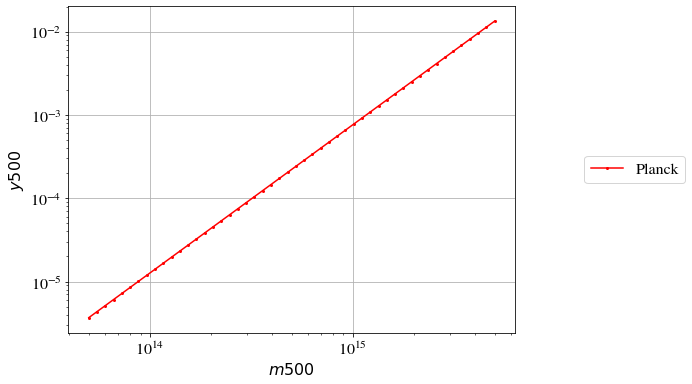

In [48]:
plt.xlabel(r"$m500$")
plt.ylabel(r"$y500$")
plt.grid()
plt.plot(m,y_planck,marker  = 'o',markersize = 2.,c='r',label='Planck')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

[]

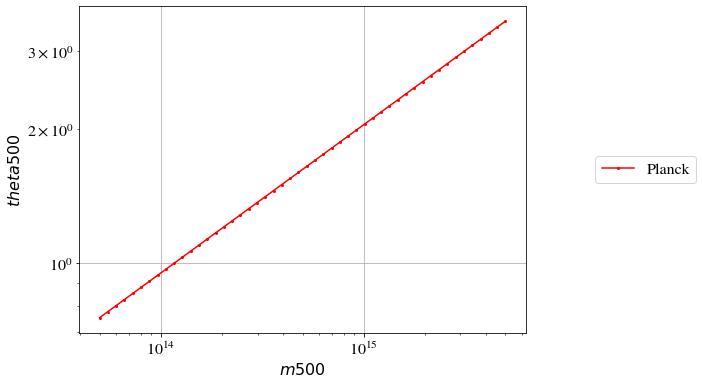

In [49]:
plt.xlabel(r"$m500$")
plt.ylabel(r"$theta500$")
plt.grid()
plt.plot(m,theta_planck,marker  = 'o',markersize = 2.,c='r',label='Planck')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

(0.0, 0.0002)

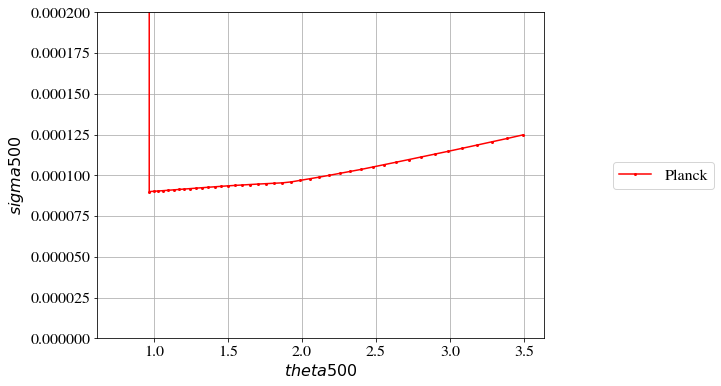

In [50]:
plt.xlabel(r"$theta500$")
plt.ylabel(r"$sigma500$")
plt.grid()
plt.plot(theta_planck,sigma_planck,marker  = 'o',markersize = 2.,c='r',label='Planck')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.ylim(0.,2e-4)

In the cell below, set the path to the file halos.pksc

In [51]:
path_to_catalogue_websky = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/'

Set the number of halos you want to consider

In [52]:
N_halos_asked = 800000

Cell/functions to read the catalogue

In [53]:
import healpy as hp


from scipy.interpolate import *
import numpy as np

omegab = websky_Omega_B
omegac = websky_Omega_M-websky_Omega_B
omegam = omegab + omegac
h      = websky_h
ns     = websky_n_s
sigma8 = websky_sigma_8

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

# from   cosmology import *
def makeACTName(RADeg, decDeg, prefix = 'ACT-CL'):
    """Makes ACT cluster name from RADeg, decDeg
    
    """
    
    actName=prefix+" J"+makeRA(RADeg)+makeDec(decDeg)
    
    return actName

def makeRA(myRADeg):
    """Makes RA part of ACT names.
    
    """
    hours=(myRADeg/360)*24
    if hours<10:
        sHours="0"+str(hours)[0]
    else:
        sHours=str(hours)[:2]
    
    mins=float(str(hours)[str(hours).index("."):])*60
    if mins<10:
        sMins="0"+str(mins)[:3]
    else:
        sMins=str(mins)[:4]
        
    return (sHours+sMins)#[:-2] # Trims off .x as not used in ACT names
        
#------------------------------------------------------------------------------------------------------------
def makeDec(myDecDeg):
    """Makes dec part of ACT names
    
    """
    
    # Positive
    if myDecDeg>0:
        if myDecDeg<10:
            sDeg="0"+str(myDecDeg)[0]
        else:
            sDeg=str(myDecDeg)[:2]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return "+"+sDeg+sMins
    else:
        if myDecDeg>-10:
            sDeg="-0"+str(myDecDeg)[1]
        else:
            sDeg=str(myDecDeg)[:3]
    
        mins=float(str(myDecDeg)[str(myDecDeg).index("."):])*60
        if mins<10:
            sMins="0"+str(mins)[:1]
        else:
            sMins=str(mins)[:2]
        
        return str(sDeg+sMins)

omegam = M.Omega_m()
h = M.h()
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3

f=open(path_to_catalogue_websky+'halos.pksc')
N=np.fromfile(f,count=3,dtype=np.int32)[0]

print('there are N=%.5e objects in the catalogue'%N)

# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
# ordered by decreasing mass
print('taking the first %.5e into account'%N_halos_asked)
N = N_halos_asked
# N = 862923142

catalog=np.fromfile(f,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))

x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)      

theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

decDeg=-1*(np.degrees(theta)-90) # Because HEALPix
RADeg=np.degrees(phi)


### e.g. project to a map, matching the websky orientations
#nside = 1024
#map   = np.zeros((hp.nside2npix(nside)))

#pix = hp.vec2pix(nside, x, y, z)
#pix = hp.ang2pix(nside, theta, phi) does the same

#weight = 1. #1 for number density, array of size(x) for arbitrary
#np.add.at(map, pix, weight)


names = []
for ra, dec in zip(RADeg, decDeg):
    names.append(makeACTName(ra, dec, prefix= 'WS-CL'))

M500c = []
for zz,mm in zip(redshift,M200m):
    mm500c = M.get_m200m_to_m500c_at_z_and_M(zz,mm*h)
    M500c.append(mm500c/h)

df_websky = {
             "redshift":redshift,
             "M200m_websky":M200m, #in m_sun
             "M500c_websky":M500c, #in m_sun
             
             "name": names,
             "decDeg":decDeg,
             "RADeg":RADeg}
df_websky = pd.DataFrame(df_websky)

there are N=8.62923e+08 objects in the catalogue
taking the first 8.00000e+05 into account


Text(0.5, 0, 'Redshit z')

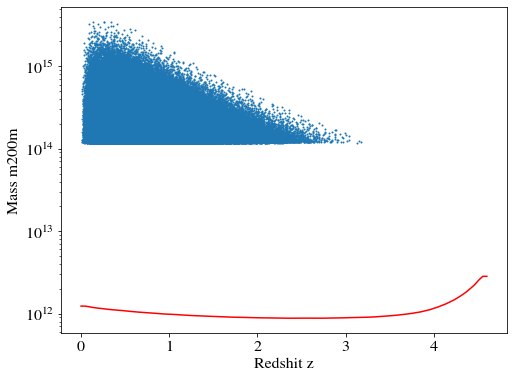

In [54]:
plt.scatter(redshift,M200m,marker='o',s=1.)
L=np.loadtxt(path_to_catalogue_websky+'halos_mass_completion_websky.txt')
plt.plot(L[:,0],L[:,1],c='r')
plt.yscale('log')
plt.ylabel('Mass m200m')
plt.xlabel('Redshit z')

In [55]:
df_websky

,redshift,M200m_websky,M500c_websky,name,decDeg,RADeg
0,0.256726,3.464257e+15,1.795846e+15,WS-CL J1751.3-1129,-11.485306,267.828247
1,0.136831,3.442972e+15,1.720939e+15,WS-CL J0212.9-4204,-42.077911,33.249195
2,0.335245,3.403789e+15,1.798915e+15,WS-CL J0925.4+7427,74.461525,141.361679
3,0.258311,3.396257e+15,1.762406e+15,WS-CL J1847.2-1345,-13.755684,281.820343
4,0.403070,3.246793e+15,1.741384e+15,WS-CL J1350.1+1422,14.376556,207.543198
...,...,...,...,...,...,...
799995,1.068359,1.185614e+14,7.123135e+13,WS-CL J1733.0-6043,-60.722733,263.263977
799996,1.128705,1.185614e+14,7.113324e+13,WS-CL J1659.4+7329,73.493454,254.863297
799997,0.346979,1.185613e+14,6.804700e+13,WS-CL J1713.0-3858,-38.981491,258.259644
799998,0.883106,1.185613e+14,7.128780e+13,WS-CL J1956.1-4246,-42.780167,299.027740


<Figure size 576x432 with 0 Axes>

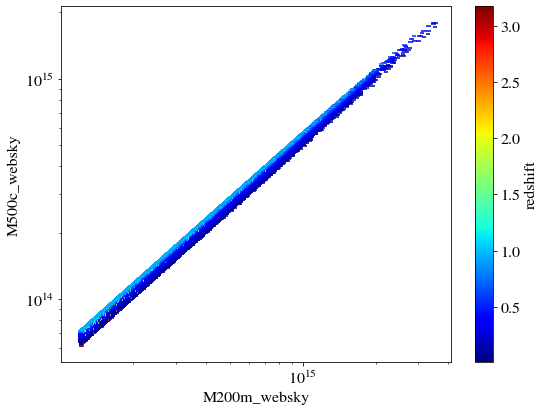

In [56]:
df = df_websky

plt.figure()
ax = df.plot(kind="scatter",x="M200m_websky",y="M500c_websky",c="redshift", cmap='jet',marker=1, sharex=False)

plt.loglog()
plt.tight_layout()

Add y500, theta500 and q (SNR) to the dataframe

In [57]:
df_websky['y500'] = np.vectorize(M.get_y_at_m_and_z)(df_websky['M500c_websky'],df_websky['redshift'])
df_websky['theta500'] = np.vectorize(M.get_theta_at_m_and_z)(df_websky['M500c_websky'],df_websky['redshift'])
df_websky['sigma500'] = np.vectorize(M.get_planck_sigma_at_theta500)(df_websky['theta500'])
df_websky['q'] = df_websky['y500']/df_websky['sigma500']
df_websky['log10q'] = np.log10(df_websky['y500']/df_websky['sigma500'])
df_websky

,redshift,M200m_websky,M500c_websky,name,decDeg,RADeg,y500,theta500,sigma500,q,log10q
0,0.256726,3.464257e+15,1.795846e+15,WS-CL J1751.3-1129,-11.485306,267.828247,0.006446,6.682216,1.944575e-04,3.314747e+01,1.520450
1,0.136831,3.442972e+15,1.720939e+15,WS-CL J0212.9-4204,-42.077911,33.249195,0.015503,11.325960,3.065993e-04,5.056500e+01,1.703850
2,0.335245,3.403789e+15,1.798915e+15,WS-CL J0925.4+7427,74.461525,141.361679,0.004596,5.390077,1.653748e-04,2.778934e+01,1.443878
3,0.258311,3.396257e+15,1.762406e+15,WS-CL J1847.2-1345,-13.755684,281.820343,0.006182,6.606866,1.927234e-04,3.207562e+01,1.506175
4,0.403070,3.246793e+15,1.741384e+15,WS-CL J1350.1+1422,14.376556,207.543198,0.003527,4.621408,1.486352e-04,2.373142e+01,1.375324
...,...,...,...,...,...,...,...,...,...,...,...
799995,1.068359,1.185614e+14,7.123135e+13,WS-CL J1733.0-6043,-60.722733,263.263977,0.000007,0.813433,1.000000e+200,6.892233e-206,-205.161640
799996,1.128705,1.185614e+14,7.113324e+13,WS-CL J1659.4+7329,73.493454,254.863297,0.000007,0.786326,1.000000e+200,6.892206e-206,-205.161642
799997,0.346979,1.185613e+14,6.804700e+13,WS-CL J1713.0-3858,-38.981491,258.259644,0.000013,1.761046,9.491956e-05,1.367319e-01,-0.864130
799998,0.883106,1.185613e+14,7.128780e+13,WS-CL J1956.1-4246,-42.780167,299.027740,0.000007,0.917047,1.000000e+200,7.053454e-206,-205.151598


Planck-like websky sample

In [70]:
planck_like_df = df_websky[df_websky['q'] >= 5.]
planck_like_df

,redshift,M200m_websky,M500c_websky,name,decDeg,RADeg,y500,theta500,sigma500,q,log10q
0,0.256726,3.464257e+15,1.795846e+15,WS-CL J1751.3-1129,-11.485306,267.828247,0.006446,6.682216,0.000194,33.147474,1.520450
1,0.136831,3.442972e+15,1.720939e+15,WS-CL J0212.9-4204,-42.077911,33.249195,0.015503,11.325960,0.000307,50.564997,1.703850
2,0.335245,3.403789e+15,1.798915e+15,WS-CL J0925.4+7427,74.461525,141.361679,0.004596,5.390077,0.000165,27.789341,1.443878
3,0.258311,3.396257e+15,1.762406e+15,WS-CL J1847.2-1345,-13.755684,281.820343,0.006182,6.606866,0.000193,32.075619,1.506175
4,0.403070,3.246793e+15,1.741384e+15,WS-CL J1350.1+1422,14.376556,207.543198,0.003527,4.621408,0.000149,23.731425,1.375324
...,...,...,...,...,...,...,...,...,...,...,...
134056,0.027000,2.562121e+14,1.319428e+14,WS-CL J0321.0+1831,18.532562,50.250313,0.003072,22.250695,0.000609,5.044939,0.702856
154829,0.018679,2.419134e+14,1.243213e+14,WS-CL J0538.2-7516,-75.276703,84.567917,0.005643,31.296604,0.000888,6.355692,0.803163
172874,0.012258,2.314080e+14,1.187279e+14,WS-CL J2348.9+0214,2.233521,357.226288,0.011861,46.692940,0.001478,8.026785,0.904542
245934,0.016890,2.001444e+14,1.032280e+14,WS-CL J2222.0+0530,5.509308,335.509766,0.004933,32.479316,0.000926,5.327808,0.726549


<Figure size 576x432 with 0 Axes>

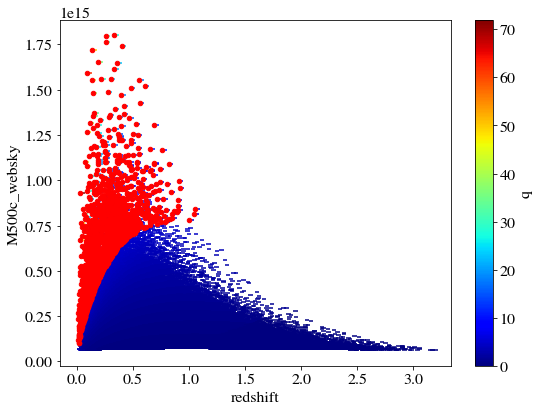

In [59]:


plt.figure()
df = df_websky
ax = df.plot(kind="scatter",x="redshift",y="M500c_websky",c="q", cmap='jet',marker=1, sharex=False)
df = planck_like_df
df.plot(kind="scatter",x="redshift",y="M500c_websky",c="red",
        sharex=False,ax=ax)
#plt.loglog()
plt.tight_layout()

zmin = 5.99948e-03 zmax = 3.17523e+00
mmin = 8.06216e+13 mmax = 2.35569e+15


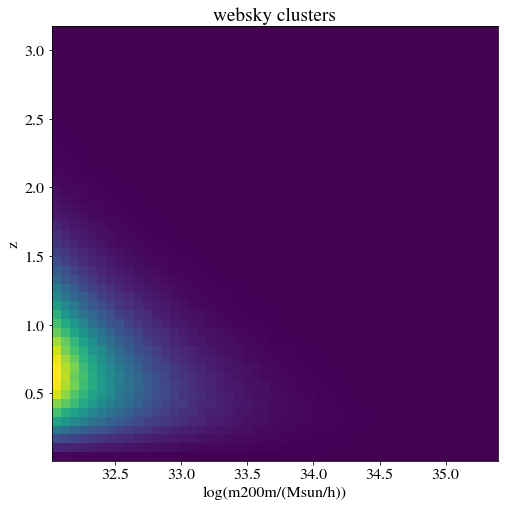

In [60]:

z = redshift
len(z)
z_min = z.min()
z_max = z.max()
# z_min = 1e-7
# z_max = 4.
z_edges = np.linspace(z_min,z_max,50)
z_min = min(z_edges)
z_max = max(z_edges)
print('zmin = %.5e'%z_min,'zmax = %.5e'%z_max)
z_edges = np.asarray(z_edges)
z_center = (z_edges[:-1] + z_edges[1:])/2.
z_center



m200_min = M200m.min()*h
m200_max = M200m.max()*h
print('mmin = %.5e'%m200_min,'mmax = %.5e'%m200_max)
m_edges = np.linspace(np.log(m200_min),np.log(m200_max),50)
m_center = (m_edges[:-1] + m_edges[1:])/2.
m_center


# x = np.random.normal(2, 1, 100)
# y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(np.log(M200m*h), z, bins=(m_edges, z_edges))
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes. 
H = H.T

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot( title='websky clusters',
        aspect="auto")
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)
plt.xlabel('log(m200m/(Msun/h))')
plt.ylabel('z')
plt.show()

In [61]:
nms = 1000
nzs = 2000
lnms = np.linspace(np.log(m200_min*1.000001),np.log(m200_max*0.99999),nms)
zs = np.linspace(z_min,z_max,nzs)

In [62]:
# masses in rows
# redshifts in column
# sum over rows -> axis 0 (1st dimension)
# sum over columns -> axis 1 (2nd dimension)
dndmdz = np.zeros((nms,nzs))

In [63]:
for (im,mm) in enumerate(lnms):
    dndmdz[im,:] = np.vectorize(M.get_volume_dVdzdOmega_at_z)(zs)*np.vectorize(M.get_dndlnM_at_z_and_M)(zs,np.exp(mm))

In [64]:
# integrate over massses at each z:
dndz = np.trapz(dndmdz,x=lnms,axis=0)
nz = np.zeros((len(z_center)))

for (iz,zz) in enumerate(z_center): 
    filter_bin = (zs>z_edges[iz]) & (zs<z_edges[iz+1])
    nz[iz] = 4.*np.pi*np.trapz(dndz[filter_bin],x=zs[filter_bin] )



In [65]:
nmz = np.zeros((len(m_center),len(z_center)))

for (im,mm) in enumerate(m_center): 
    filter_binm = (lnms>m_edges[im]) & (lnms<m_edges[im+1])
    dndz_m = np.trapz(dndmdz[filter_binm,:],x=lnms[filter_binm],axis=0)

    for (iz,zz) in enumerate(z_center): 
        filter_bin = (zs>z_edges[iz]) & (zs<z_edges[iz+1])
        nmz[im,iz] = 4.*np.pi*np.trapz(dndz_m[filter_bin],x=zs[filter_bin] )




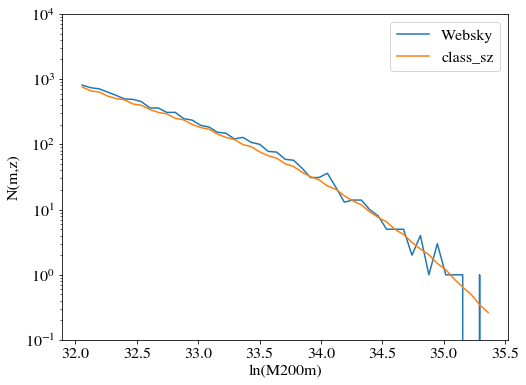

In [69]:
i = 1
plt.plot(m_center,H[i,:],label='Websky')
plt.plot(m_center,nmz.T[i,:],label='class_sz')
plt.legend()
plt.xlabel('ln(M200m)')
plt.ylabel('N(m,z)')
plt.yscale('log')
plt.ylim(1e-1,1e4)
# plt.xlim(32,34.)
plt.show()



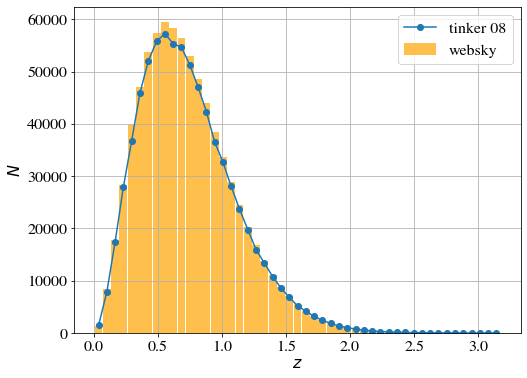

In [67]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
# plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,
                                        N_clusters_z), 
                            bins=z_edges, 
                            color='orange',
                            alpha=0.7, 
                            rwidth=0.95,
                            label='websky')
plt.plot(z_center,nz,label='tinker 08',marker='o')
# n, bins, patches = plt.hist(x=np.repeat(z_center,
#                                         nz), 
#                             bins=z_edges, 
#                             color='orange',
#                             alpha=0.7, 
#                             rwidth=0.95,
#                             label='Tinker')

# n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='blue',alpha=0.7, rwidth=0.95,label=r'SO (~$10^{4}$) - class_sz')



plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.yscale('linear')
plt.show()

In [68]:
N_clusters_z/nz

array([0.98495306, 1.06490813, 1.02415683, 1.01392777, 1.08247604,
       1.02238378, 1.03215952, 1.02876322, 1.03738905, 1.05535503,
       1.03159169, 1.03206771, 1.0317835 , 1.03950281, 1.05321273,
       1.0293166 , 1.03353244, 1.03633727, 1.02932556, 1.05886119,
       1.02567549, 1.03673279, 1.02407711, 1.03134906, 1.05392179,
       1.02245311, 1.04022815, 0.99936363, 1.0253581 , 1.04959537,
       1.05074707, 1.02415293, 0.98469796, 1.00152248, 1.10581686,
       1.01776819, 0.96656359, 0.94561477, 1.10738529, 1.04725983,
       0.93965018, 1.08313103, 0.93831288, 0.94971071, 1.1761786 ,
       0.94609987, 1.42202705, 0.        , 2.00843972])